In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import array_sensitivity

In [5]:
# Set instrument parameters
c = 3e8
min_freq_hz = 130e6  # z=10
max_freq_hz = 250e6  # z=5
freq_hz = np.mean([min_freq_hz, max_freq_hz])
tsys_k_old = 100  # placeholder value
tsys_k = 50 *(c/freq_hz)**(2.56)
print(tsys_k)
aperture_efficiency = 0.7
# field_of_view_deg2 = 2830.0  # Approximately 60 deg FWHM
antenna_diameter_m = 3  # Assume 3 m ground planes
freq_resolution_hz = 130.2e3
int_time_s = 15.0 * 60  # 15 minutes in each survey field
max_bl_m = None

antpos_filepath = "W2-17.cfg"
wedge_ext = 90.0
pointing_ang = 0.0

antpos = array_sensitivity.get_antpos(antpos_filepath)
baselines_m = array_sensitivity.get_baselines(antpos)

freq_array_hz = np.arange(min_freq_hz, max_freq_hz, freq_resolution_hz)
delay_array_s = np.fft.fftshift(
    np.fft.fftfreq(len(freq_array_hz), d=freq_resolution_hz)
)
kpar_conv_factor = array_sensitivity.get_kpar_conversion_factor(freq_hz)
max_kpar = kpar_conv_factor * np.max(delay_array_s)

kperp_conv_factor = array_sensitivity.get_kperp_conversion_factor(freq_hz)
max_baseline_wl = np.max(np.sqrt(np.sum(baselines_m**2.0, axis=1))) * max_freq_hz / c
max_kperp = kperp_conv_factor * max_baseline_wl
max_k = np.sqrt(max_kpar**2.0 + max_kperp**2.0)

# Define bin edges:
k_bin_size = 0.1
min_k = 0.02
bin_edges = np.arange(min_k, max_k, k_bin_size)
kpar_bin_edges = np.arange(0, max_kpar, k_bin_size)
kperp_bin_edges = np.arange(0, max_kperp, k_bin_size)

160.98714479731228


In [ ]:
(c / freq_hz)**2/3  # SEFD, calculated Gregg's way

0.8310249307479225

In [ ]:
np.pi / 4 * antenna_diameter_m**2 * 0.7  # SEFD, calculated the original way

4.948008429403924

In [ ]:
c / freq_hz * np.sqrt(4 / (3 * np.pi * aperture_efficiency))  # Equivalent aperture diameter

1.2294562122505652

In [6]:
with open("simulation_outputs/thermal_noise_lowband.npy", "rb") as f:
    nsamples = np.load(f)
    binned_ps_variance = np.load(f)
    true_bin_edges = np.load(f)
    true_bin_centers = np.load(f)
    nsamples_2d = np.load(f, allow_pickle=True)
    binned_ps_variance_2d = np.load(f, allow_pickle=True)
f.close()

In [7]:
# Adjust values based on updated Tsys
binned_ps_variance *= (tsys_k / tsys_k_old)**4.
binned_ps_variance_2d *= (tsys_k / tsys_k_old) ** 4

In [8]:
print(nsamples)

[   1981    9711   23741   44209   70272  102675  141123  184892  234804
  290050  351976  419437  493996  573761  661845  762208  867954  978024
 1097742 1220847 1349067 1487465 1628989 1335882  155448       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0       0       0       0
       0       0       0       0       0       0   

/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_44782/1826067633.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  use_cmap = cm.get_cmap("inferno").copy()


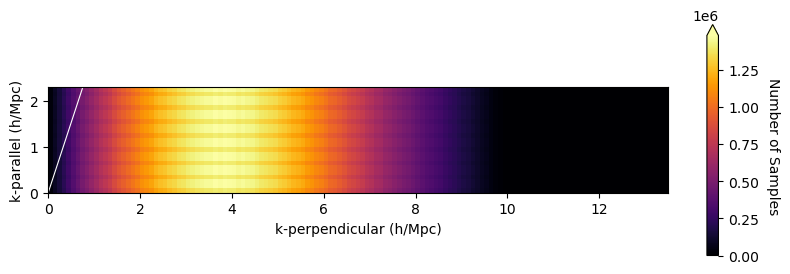

In [9]:
# Make 2D Nsamples plot from restored data

# Get wedge slope
kperp_conv_factor = array_sensitivity.get_kperp_conversion_factor(freq_hz)
kpar_conv_factor = array_sensitivity.get_kpar_conversion_factor(freq_hz)
wedge_slope = kpar_conv_factor / (kperp_conv_factor * freq_hz)

field_of_view_radius = 60.0
fov_wedge_slope = wedge_slope * np.sin(np.radians(field_of_view_radius))

fig, ax = plt.subplots(figsize=(10, 3))
use_cmap = cm.get_cmap("inferno").copy()
cax = ax.imshow(
    nsamples_2d.T,
    origin="lower",
    interpolation="none",
    extent=[
        np.min(kperp_bin_edges),
        np.max(kperp_bin_edges),
        np.min(kpar_bin_edges),
        np.max(kpar_bin_edges),
    ],
    vmin=0,
    vmax=np.max(nsamples_2d),
    cmap=use_cmap,
    # norm="log",
    aspect=10.0,
)
ax.set_xlabel("k-perpendicular (h/Mpc)")
ax.set_ylabel("k-parallel (h/Mpc)")
ax.set_xlim([0, np.max(kperp_bin_edges)])
ax.set_ylim([0, np.max(kpar_bin_edges)])
ax.set_aspect("equal")
plt.plot(
    [0, np.max(kperp_bin_edges)],
    [0, wedge_slope * np.max(kperp_bin_edges)],
    c="white",
    linewidth=0.8,
)
#plt.plot(
#    [0, np.max(kperp_bin_edges)],
#    [0, fov_wedge_slope * np.max(kperp_bin_edges)],
#    "--",
#    c="white",
#    linewidth=0.8,
#)
# ax.grid(linewidth=.5)
cbar = fig.colorbar(cax, extend="max")
cbar.set_label("Number of Samples", rotation=270, labelpad=15)
plt.show()

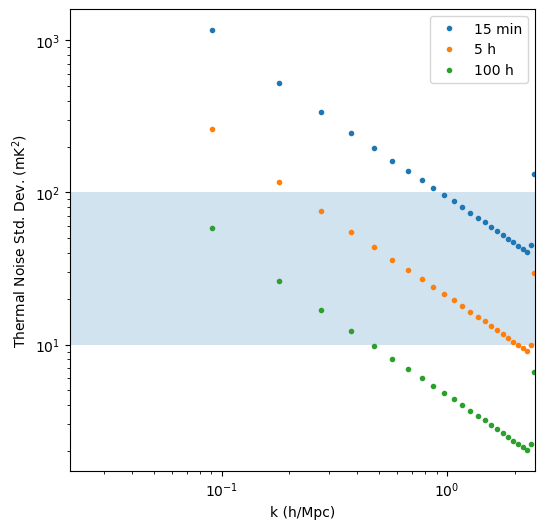

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
labels = ["15 min", "5 h", "100 h"]
for int_time_ind, integration_time_minutes in enumerate([15, 300, 6000]):
    binned_ps_variance * 15 / integration_time_minutes
    ax.plot(
        true_bin_centers,
        np.sqrt(binned_ps_variance * 15 / integration_time_minutes),
        ".",
        label = labels[int_time_ind]
    )
ax.set_xlabel("k (h/Mpc)")
ax.set_ylabel("Thermal Noise Std. Dev. (mK$^2$)")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim(np.nanmin(true_bin_edges), np.nanmax(true_bin_edges))
ax.fill_between(
    [np.nanmin(true_bin_edges), np.nanmax(true_bin_edges)], 10, 100, alpha=0.2
)
ax.legend()
plt.show()

In [11]:
import sys
sys.path.append("/Users/ruby/Astro/eor_limits/eor_limits")
import process_mesinger_2016, process_munoz_2021, process_pagano_2020

In [12]:
redshift = 7.5
messinger_model_1 = process_mesinger_2016.get_mesinger_2016_line(
    model="faint", redshift=redshift
)
messinger_model_2 = process_mesinger_2016.get_mesinger_2016_line(
    model="bright", redshift=redshift
)
munoz_model_1 = process_munoz_2021.get_munoz_2021_line(model="EOS", redshift=redshift)
munoz_model_2 = process_munoz_2021.get_munoz_2021_line(model="OPT", redshift=redshift)
pagano_model_1 = process_pagano_2020.get_pagano_2020_line(beta=1, redshift=redshift)
pagano_model_2 = process_pagano_2020.get_pagano_2020_line(beta=-1, redshift=redshift)

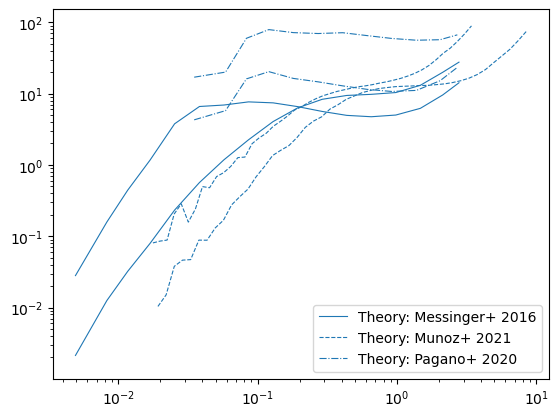

In [13]:
fig, ax = plt.subplots()
ax.plot(messinger_model_1["k"], messinger_model_1["delta_squared"], "-", color="tab:blue", linewidth=0.8)
ax.plot(
    messinger_model_2["k"],
    messinger_model_2["delta_squared"],
    "-",
    color="tab:blue",
    linewidth=0.8,
    label="Theory: Messinger+ 2016",
)
ax.plot(
    munoz_model_1["k"],
    munoz_model_1["delta_squared"],
    "--",
    color="tab:blue",
    linewidth=0.8
)
ax.plot(
    munoz_model_2["k"],
    munoz_model_2["delta_squared"],
    "--",
    color="tab:blue",
    linewidth=0.8,
    label="Theory: Munoz+ 2021",
)
ax.plot(
    pagano_model_1["k"],
    pagano_model_1["delta_squared"],
    "-.",
    color="tab:blue",
    linewidth=0.8,
)
ax.plot(
    pagano_model_2["k"],
    pagano_model_2["delta_squared"],
    "-.",
    color="tab:blue",
    linewidth=0.8,
    label="Theory: Pagano+ 2020",
)
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
plt.show()

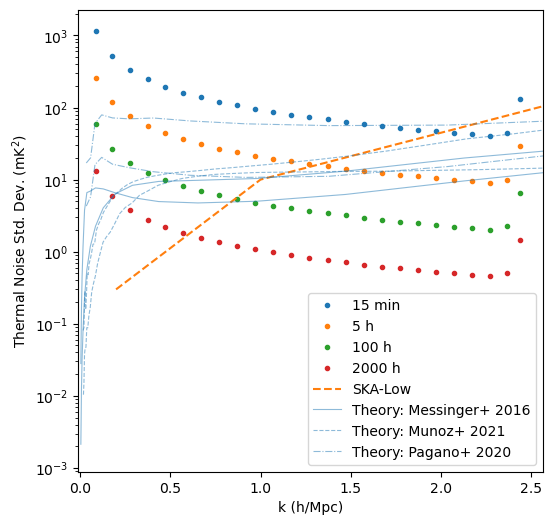

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))
labels = ["15 min", "5 h", "100 h", "2000 h"]
for int_time_ind, integration_time_minutes in enumerate([15, 300, 6000, 120000]):
    ax.plot(
        true_bin_centers,
        np.sqrt(binned_ps_variance * 15 / integration_time_minutes),
        ".",
        label=labels[int_time_ind],
    )
ax.set_xlabel("k (h/Mpc)")
ax.set_ylabel("Thermal Noise Std. Dev. (mK$^2$)")
ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlim(np.nanmin(true_bin_centers)-10e-2, np.nanmax(true_bin_edges)+.1)


# Add other sensitivity lines
ax.plot([0.2, 1, 3], [0.3, 10, 200], "--", color="tab:orange", label="SKA-Low")

# Add theory lines
ax.plot(
    messinger_model_1["k"],
    messinger_model_1["delta_squared"],
    "-",
    color="tab:blue",
    linewidth=0.8,
    alpha=0.5,
)
ax.plot(
    messinger_model_2["k"],
    messinger_model_2["delta_squared"],
    "-",
    color="tab:blue",
    linewidth=0.8,
    label="Theory: Messinger+ 2016",
    alpha=0.5,
)
ax.plot(
    munoz_model_1["k"],
    munoz_model_1["delta_squared"],
    "--",
    color="tab:blue",
    linewidth=0.8,
    alpha=0.5,
)
ax.plot(
    munoz_model_2["k"],
    munoz_model_2["delta_squared"],
    "--",
    color="tab:blue",
    linewidth=0.8,
    label="Theory: Munoz+ 2021",
    alpha=0.5,
)
ax.plot(
    pagano_model_1["k"],
    pagano_model_1["delta_squared"],
    "-.",
    color="tab:blue",
    linewidth=0.8,
    alpha=0.5,
)
ax.plot(
    pagano_model_2["k"],
    pagano_model_2["delta_squared"],
    "-.",
    color="tab:blue",
    linewidth=0.8,
    label="Theory: Pagano+ 2020",
    alpha=0.5,
)


ax.legend()
plt.show()

In [15]:
models = [
    messinger_model_1,
    messinger_model_2,
    munoz_model_1,
    munoz_model_2,
    pagano_model_1,
    pagano_model_2,
]
models_interpolated = np.zeros((len(true_bin_centers), len(models)))
for model_ind, model in enumerate(models):
    models_interpolated[:, model_ind] = np.interp(
        true_bin_centers, model["k"], model["delta_squared"]
    )
models_interpolated_max = np.nanmax(models_interpolated, axis=1)
models_interpolated_min = np.nanmin(models_interpolated, axis=1)

/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_44782/2139847770.py:14: RuntimeWarning: All-NaN slice encountered
  models_interpolated_max = np.nanmax(models_interpolated, axis=1)
/var/folders/x0/sh3xmymj56x6t_05l6hx76zw0000gn/T/ipykernel_44782/2139847770.py:15: RuntimeWarning: All-NaN slice encountered
  models_interpolated_min = np.nanmin(models_interpolated, axis=1)


In [36]:
import yaml
integration_time_minutes = 60*1000
sensitivity = (np.sqrt(binned_ps_variance * 15 / integration_time_minutes))[0:30]
print((np.sqrt(binned_ps_variance * 15 / integration_time_minutes))[0:30])
print(true_bin_edges[0:30])

data = {"sensitivity (mK^2)": sensitivity.tolist(), "bin edges (h/Mpc)": [str(element) for element in true_bin_edges[0:30]]}
with open('dsa2000_low_sensitivity.yaml', 'w') as file:
        yaml.dump(data, file)

[18.39066118  8.30629984  5.31239155  3.89299849  3.08779475  2.55450775
  2.17891697  1.90362115  1.68922241  1.51985846  1.37969489  1.26388108
  1.16460289  1.08062266  1.006147    0.93756812  0.87860006  0.82768451
  0.78124894  0.74081362  0.7047301   0.67114476  0.64132845  0.70819936
  2.07609399         inf         inf         inf         inf         inf]
[[0.02119818 0.11999378]
 [0.12009685 0.219971  ]
 [0.22000454 0.31999894]
 [0.32000352 0.4199974 ]
 [0.42000735 0.51999994]
 [0.52000305 0.61999817]
 [0.62000032 0.71999163]
 [0.72000396 0.81999983]
 [0.82000237 0.91999942]
 [0.92000148 1.01999974]
 [1.02000036 1.11999991]
 [1.12000019 1.21999991]
 [1.22000054 1.31999991]
 [1.32000037 1.4199997 ]
 [1.42000002 1.5199997 ]
 [1.5200007  1.61999985]
 [1.62000008 1.71999993]
 [1.72000034 1.81999993]
 [1.82000004 1.91999991]
 [1.92000021 2.01999992]
 [2.02000003 2.11999991]
 [2.12000015 2.21999993]
 [2.22000001 2.31999993]
 [2.32000013 2.41999993]
 [2.42000019 2.46598853]
 [       

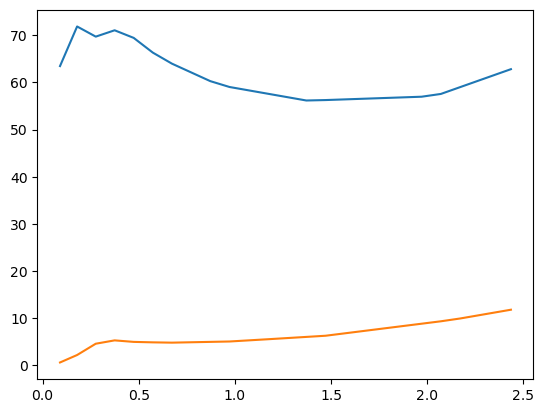

In [16]:
plt.plot(true_bin_centers, models_interpolated_max)
plt.plot(true_bin_centers, models_interpolated_min)

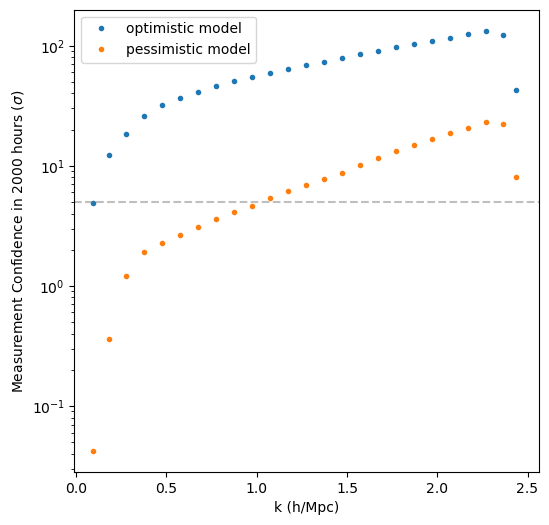

In [17]:
binned_stddev_100hr = np.sqrt(binned_ps_variance * 15 / 120000)
measurment_confidence_opt = models_interpolated_max / binned_stddev_100hr
measurment_confidence_pes = models_interpolated_min / binned_stddev_100hr
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(true_bin_centers, measurment_confidence_opt, ".", label="optimistic model")
ax.plot(true_bin_centers, measurment_confidence_pes, ".", label="pessimistic model")
xlim = [np.nanmin(true_bin_centers) - 10e-2, np.nanmax(true_bin_edges) + 0.1]
ax.set_xlim(xlim)
ax.plot(xlim, [5,5], "--", color="grey", alpha=0.5)
ax.set_yscale("log")
ax.set_xlabel("k (h/Mpc)")
ax.set_ylabel("Measurement Confidence in 2000 hours ($\sigma$)")
ax.legend()
plt.show()

In [18]:
max_kperp_mode = np.max(kpar_bin_edges) / wedge_slope
print(max_kperp_mode)
max_kperp_mode_wl = max_kperp_mode / kperp_conv_factor
print(max_kperp_mode_wl)

0.7540136108517772
716.1709588207734


In [19]:
max_baseline_array_wl = np.max(kperp_bin_edges) / kperp_conv_factor
print(max_baseline_array_wl)
wavelength = c / freq_hz
max_baseline_array_m = max_baseline_array_wl * wavelength
print(max_baseline_array_m)

12822.458116052527
20245.986499030307


In [20]:
max_baseline_retained_m = max_kperp_mode_wl * wavelength
print(max_baseline_retained_m)

1130.7962507696423


In [21]:
bl_lengths = np.sqrt(np.sum(np.abs(baselines_m)**2.0, axis=1))
len(np.where(bl_lengths < max_baseline_retained_m)[0])

45904

In [22]:
len(bl_lengths)

2096128

In [23]:
45904 / 2096128.0

0.021899425989252565

[[6.00000000e+01 2.64071623e+04]
 [8.00000000e+01 3.25493645e+03]
 [1.20000000e+02 1.59922692e+02]
 [1.60000000e+02 3.12662475e+01]
 [1.80000000e+02 1.38021271e+01]
 [2.00000000e+02 6.69094320e+00]
 [2.20000000e+02 3.68191981e+00]
 [2.40000000e+02 2.49009582e+00]]
[[6.00000000e+01 2.48281691e+03]
 [8.00000000e+01 3.01008054e+02]
 [1.20000000e+02 1.48578506e+01]
 [1.60000000e+02 2.85786541e+00]
 [1.80000000e+02 1.32918457e+00]
 [2.00000000e+02 5.99532663e-01]
 [2.20000000e+02 3.29758489e-01]
 [2.40000000e+02 2.27663101e-01]]


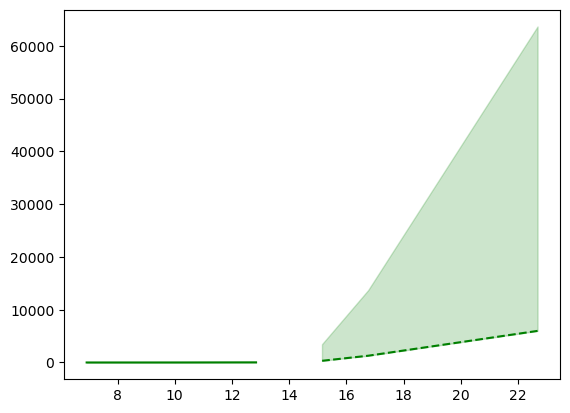

In [41]:
import h5py

HERA_SENSE_FILE_PESS = "H6C-75-ants.h5"
H6_sense = h5py.File(HERA_SENSE_FILE_PESS)
H6_freqs = sorted(np.array([k.split()[0] for k in H6_sense.keys()], dtype=float))
H6_minsense = np.array(
    [[k.split()[0], np.min(H6_sense[k]["one_sigma_thermal"])] for k in H6_sense.keys()],
    dtype=float,
)
H6_minsense_pess = H6_minsense[H6_minsense[:, 0].argsort()]
print(H6_minsense_pess)

HERA_SENSE_FILE = "H6C-209-ants.h5"
H6_sense = h5py.File(HERA_SENSE_FILE)
H6_freqs = sorted(np.array([k.split()[0] for k in H6_sense.keys()], dtype=float))
H6_minsense = np.array(
    [[k.split()[0], np.min(H6_sense[k]["one_sigma_thermal"])] for k in H6_sense.keys()],
    dtype=float,
)
H6_minsense_mid = H6_minsense[H6_minsense[:, 0].argsort()]
print(H6_minsense_mid)

# lets break up the HERA sensitivity into low and high bands
H6_high_inds = np.argwhere(H6_minsense_mid[:, 0] > 110).squeeze()
H6_low_inds = np.argwhere(H6_minsense_mid[:, 0] < 90).squeeze()
plt.fill_between(
    1421 / H6_minsense_mid[H6_high_inds, 0] + 1,
    H6_minsense_mid[H6_high_inds, 1],
    H6_minsense_pess[H6_high_inds, 1],
    color="g",
    alpha=0.2,
)
plt.plot(
    1421 / H6_minsense_mid[H6_high_inds, 0] + 1,
    H6_minsense_mid[H6_high_inds, 1],
    label="HERA Full Season",
    color="g",
)

# according to Fagnoni 2019 the low band antenna is ~7x less sensitive (looking at Antenna sensitivity in Aeff/Tsys)
# specifically comparing 125MHz to 75MHz
#   21cmSense assumes collecting area scales as lamda^2 which would only be a factor of 125^2/75^2 ~ 2.77.
#   thus the sensitivity estimates should be ~7/2.77~2.5x higher
HLscale = 2.5
H6_sens_fit_mid = np.poly1d(np.polyfit(H6_minsense_mid[:, 0], H6_minsense_mid[:, 1], 4))
H6_sens_fit_pess = np.poly1d(
    np.polyfit(H6_minsense_pess[:, 0], H6_minsense_pess[:, 1], 4)
)
H6_freqs = np.append(
    H6_minsense_mid[H6_low_inds, 0], 88
)  # add in a point at the bottom of the FM band
plt.fill_between(
    1421 / H6_freqs - 1,
    H6_sens_fit_mid(H6_freqs) * HLscale,
    H6_sens_fit_pess(H6_freqs) * HLscale,
    color="g",
    alpha=0.2,
)
plt.plot(
    1421 / H6_freqs - 1,
    H6_sens_fit_mid(H6_freqs) * HLscale,
    label="HERA Full Season",
    color="g",
    ls="--",
)

In [44]:
H6_sense[k].keys()

NameError: name 'k' is not defined